In [1]:
import os
import torch
from functools import partial
from torch import nn
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from IPython import display
import numpy as np
import torch.nn.functional as F
from tqdm.auto import tqdm
import functools
from einops import rearrange, repeat
from scipy.linalg import sqrtm

from scipy.stats import gaussian_kde

from models.mlp import ResNet
from models.pfgmpp_loss import EDMLoss
from sdes.backward import edm_sampler
from likelihood import get_likelihood_fn

from sdes.forward import uncon_VP_1D
from sdes.backward import uncon_EulerMaruyama, ODE_uncon_EulerMaruyama
from likelihood import get_likelihood_fn

/home/tonyz/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


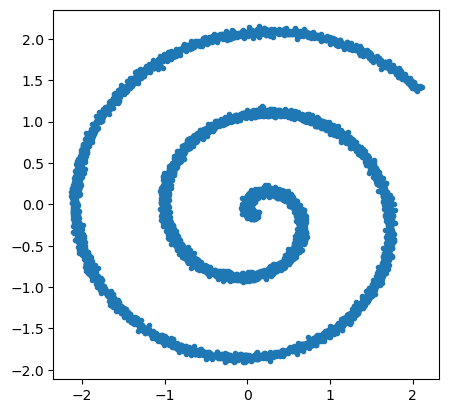

In [2]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

def data_gen(length):
  t0=5
  k = 1.5
  strength = 0.03
  train_data = torch.zeros((length,2))
  train_param = torch.rand(length)*10-5
  train_data[:, 0]  = 0.2*k*(train_param[:]-t0)*torch.cos(k*(train_param[:]-t0))+strength*torch.randn(length)
  train_data[:, 1]  = 0.2*k*(train_param[:]-t0)*torch.sin(k*(train_param[:]-t0))+strength*torch.randn(length)
  return train_data, train_param

def get_pos_from_rad(rad, k=1.5, t0=5):
  tmp_arr = torch.zeros([rad.shape[0],2])
  tmp_arr[:, 0]  = 0.2*k*(rad-t0)*torch.cos(k*(rad-t0))
  tmp_arr[:, 1]  = 0.2*k*(rad-t0)*torch.sin(k*(rad-t0))
  mu = torch.mean(tmp_arr, dim=0).unsqueeze(0)
  std = torch.std(tmp_arr, dim=0).unsqueeze(0)
  tmp_arr = (tmp_arr - mu) / std
  return tmp_arr.cpu().detach().numpy()

def get_pos_from_single_rad(rad, data_mu, data_std, k=1.5, t0=5):
  tmp_arr = torch.zeros([rad.shape[0],2])
  tmp_arr[:, 0]  = 0.2*k*(rad-t0)*torch.cos(k*(rad-t0))
  tmp_arr[:, 1]  = 0.2*k*(rad-t0)*torch.sin(k*(rad-t0))
  tmp_arr = (tmp_arr - data_mu) / data_std
  return tmp_arr.cpu().detach().numpy()

def swiss_roll_eval(xy_coord, rad, **kwargs):
  data_mu = kwargs.get('data_mu')
  data_std = kwargs.get('data_std')
  if data_mu is None or data_std is None:
    raise ValueError("Both data_mu and data_std must be provided")
  true_xy = get_pos_from_single_rad(rad, data_mu, data_std)
  return torch.tensor(true_xy, device=xy_coord.device) - xy_coord

def loss_fn_vp(model, x, c, beta_min, beta_max, eps=1e-5):
  """The loss function for training score-based generative models VP SDE

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    beta_min: hyperparameter defining noise scales
    beta_max: hyperparameter defining noise scales
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  z = torch.randn_like(x, device=x.device)
  mu = x*torch.exp(-0.25*random_t**2*(beta_max-beta_min)-0.5*random_t*beta_min)[:, None]
  std = torch.sqrt(1-torch.exp(-0.5*random_t**2*(beta_max-beta_min)-random_t*beta_min))
  perturbed_x = mu + z*std[:, None]
  score = model(perturbed_x, c, random_t)

  loss = torch.mean(torch.sum((score*std[:, None] + z)**2, dim=1))
  #loss = torch.mean(torch.sum((score + z)**2, dim=1))
  return loss

def p_losses(score_model, sde, x0):
    # compute losses (including ELBO, score-matching loss)
    t = torch.rand(x0.shape[0], device=x0.device) * (1. - 1e-5) + 1e-5
    x_perturbed, std, z = sde.forward(x0, t)
    #context_mask = torch.zeros_like(c)
    score_pred = score_model(x_perturbed, t)

    loss_dict = {}

    log_prefix = 'train' 

    # score-mathcing objective function
    score_loss = torch.sum((score_pred*std + z)**2, dim=(1))

    loss_dict.update({f'{log_prefix}/loss_score': score_loss.mean()})

    lamb = sde.g(t)**2
    loss_vlb = lamb*score_loss
    loss_vlb = loss_vlb.mean()
    loss_dict.update({f'{log_prefix}/loss_vlb': loss_vlb})

    loss = score_loss.mean()

    loss_dict.update({f'{log_prefix}/loss': loss})

    return loss, loss_dict

# calculate frechet inception distance
def fid_metric(act1, act2):
  # calculate mean and covariance statistics
  mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
  mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
  # calculate sum squared difference between means
  ssdiff = np.sum((mu1 - mu2)**2.0)
  # calculate sqrt of product between cov
  if np.isnan(sigma1).any() or np.isnan(sigma2).any() or np.isinf(sigma1).any() or np.isinf(sigma2).any():
    print("Invalid values detected in sigma1 or sigma2. Returning NaN for metrics.")
    return (np.nan, np.nan)
  covmean = sqrtm(sigma1.dot(sigma2))
  # check and correct imaginary numbers from sqrt
  if np.iscomplexobj(covmean):
    covmean = covmean.real
  # calculate score
  fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
  return fid

seed_everything(111)
data_type = 'swiss_roll' # 'circle'
#ndim = 2

train_data_length = 8192

xlim_min = -1.5
xlim_max = 2.0
ylim_min = -1.5
ylim_max = 2.0

train_data, _ = data_gen(train_data_length)
data_mu = torch.mean(train_data, dim=0).unsqueeze(0)
data_std = torch.std(train_data, dim=0).unsqueeze(0)
train_data = (train_data - data_mu) / data_std
#train_data = 2*(train_data-torch.min(train_data, dim=0)[0])/(torch.max(train_data,dim=0)[0]-torch.min(train_data, dim=0)[0])-1
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]
train_set, val_set = torch.utils.data.random_split(train_set, [1,0])

batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)
#val_loader = torch.utils.data.DataLoader(
#    val_set, batch_size=batch_size, shuffle=True
#)

plt.plot(train_data[train_set.indices, 0], train_data[train_set.indices, 1], ".")
#plt.plot(train_data[val_set.indices, 0], train_data[val_set.indices, 1], ".")
#plt.xlim(xlim_min, xlim_max)
#plt.ylim(ylim_min, ylim_max)
plt.gca().set_aspect('equal', adjustable='box')

In [3]:
class VPLoss:
    def __init__(self, beta_d=19.9, beta_min=0.1, epsilon_t=1e-5):
        self.beta_d = beta_d
        self.beta_min = beta_min
        self.epsilon_t = epsilon_t

    def __call__(self, net, images, labels, augment_pipe=None):
        rnd_uniform = torch.rand([images.shape[0], 1], device=images.device)
        sigma = self.sigma(1 + rnd_uniform * (self.epsilon_t - 1))
        weight = 1 / (sigma ** 2 + 1e-10)
        y, augment_labels = augment_pipe(images) if augment_pipe is not None else (images, None)
        n = torch.randn_like(y) * sigma
        D_yn = net(y + n, sigma, labels, augment_labels=augment_labels)
        loss = weight * ((D_yn - y) ** 2)
        return loss

    def sigma(self, t):
        t = torch.as_tensor(t)
        return ((0.5 * self.beta_d * (t ** 2) + self.beta_min * t).exp() - 1).sqrt()

In [4]:
# denoising architecture
hidden_size = 128
hidden_layers = 6
embedding_size = 128
time_embedding = 'sinusoidal'
input_embedding = 'sinusoidal'
cond_embedding = 'sinusoidal'

# optimization
learning_rate = 1e-4
num_epochs = 500

beta_min = 0.1# for SDE noise [VP]
beta_max = 19.9 # for SDE noise [VP]

device='cuda'
#output_step = 50

#beta_min_values = np.logspace(-8, -2, num=7) 
#beta_max_values = np.hstack((np.array([1]),np.linspace(10, 100, num=10)))
D_values = np.array([64])
last_loss_values = []
fid_values = []
avg_nll_values = []
#'''
for D in D_values:
    seed_everything(0)

    model = ResNet(2, 2, label_dim=0, augment_dim=0, model_channels=128,
                    channel_mult=[1,1,1], channel_mult_emb=1, num_blocks=2,
                    dropout=0, emb_type="sinusoidal", channel_mult_noise=1)
    model.train()
    model.to(device)

    #vp = uncon_VP_1D(beta_min, beta_max)

    #PFGMPP_loss_fn = EDMLoss(D=D, N=2, gamma=5) #gamma dummy var for now
    VP_loss_fn = VPLoss(beta_d=beta_max, beta_min=beta_min, epsilon_t=1e-5)

    optimizer = torch.optim.Adam(
            model.parameters(),
            lr=learning_rate,
        )

    global_step = 0
    frames = []
    loss_v = []
    loss_avg = []
    #val_loss_avg = []

    #tqdm_epoch = tqdm.notebook.trange(num_epochs)
    best_val_loss = float('inf')
    save_path = './model.pth' 
    print('training ...')
    for epoch in range(num_epochs):
        model.train()
        avg_loss = 0.
        num_items = 0

        for step, batch in enumerate(train_loader):
            x = batch[0]
            c = batch[1]
            x = x.to(device)
            c = c.to(device)
            optimizer.zero_grad()
            #loss = PFGMPP_loss_fn(model, x, None, None, False, True, None)
            loss = VP_loss_fn(model, x, None, None)
            loss = loss.sum().mul(1 / x.shape[0])
            #print(loss.item(), 1 / x.shape[0])
            #loss,_ = p_losses(model, vp, x)
            
            loss.backward()
            optimizer.step()
            avg_loss += loss.item() * x.shape[0]
            num_items += x.shape[0]
            loss_v.append(loss.item())
            loss_avg.append(avg_loss / num_items)
        # Print the averaged training loss so far.
        if epoch % 100 == 0 or epoch == num_epochs - 1:
            print('D: ', D, 'loss: ', avg_loss / num_items)
    torch.save(model.state_dict(), 'mdl_weights/'+'D_'+str(D)+'.pth')

    last_loss = avg_loss / num_items
    #vp_sampler = uncon_EulerMaruyama(1000, 1e-5, train_data_length)
    #vp_ode_sampler = ODE_uncon_EulerMaruyama(1000, 1e-5, 10000, 1e-5, 1e-5)
    latent = torch.randn(train_data_length, 2, device=device)
    samples = edm_sampler(model, latent, None, 100, pfgmpp=True)
    #samples, _ = vp_ode_sampler(model, vp, train_data.shape, device)
    samples = samples.detach().cpu().numpy()
    fid = fid_metric(samples, train_data.detach().cpu().numpy())
    inverse_scaler = 1 # dummy param
    #likelihood_fn = get_likelihood_fn(vp, inverse_scaler)
    #nll = likelihood_fn(model, train_data.to(device))[0]
    #avg_nll = np.mean(nll.detach().cpu().numpy())
    
    last_loss_values.append(last_loss)
    fid_values.append(fid)
    #avg_nll_values.append(avg_nll)
#'''

training ...
D:  64 loss:  647.9752951413393
D:  64 loss:  43.631947971880436
D:  64 loss:  25.599917646497488
D:  64 loss:  21.671067621558905
D:  64 loss:  42.83575504645705
D:  64 loss:  23.547332268208265


In [4]:
D=128
seed_everything(0)

model = ResNet(2, 2, label_dim=0, augment_dim=0, model_channels=128,
                channel_mult=[1,1,1], channel_mult_emb=1, num_blocks=2,
                dropout=0, emb_type="sinusoidal", channel_mult_noise=1)
model.train()
model.to(device)

PFGMPP_loss_fn = EDMLoss(D=D, N=2, gamma=5) #gamma dummy var for now
model.load_state_dict(torch.load('mdl_weights/D_128.pth'))


In EDM loss: D:128, N:2


<All keys matched successfully>

In [4]:
import pandas as pd

results_df = pd.DataFrame({
    'D': np.repeat(D_values, len(D_values)),
    'last_loss': last_loss_values,
    'fid': fid_values,
    #'avg_nll': avg_nll_values
})

print(results_df)

     D  last_loss       fid
0  128  132.23554  0.064125


In [18]:
#results_df.to_csv("results.csv", index=False)
results_df = pd.read_csv("results.csv")

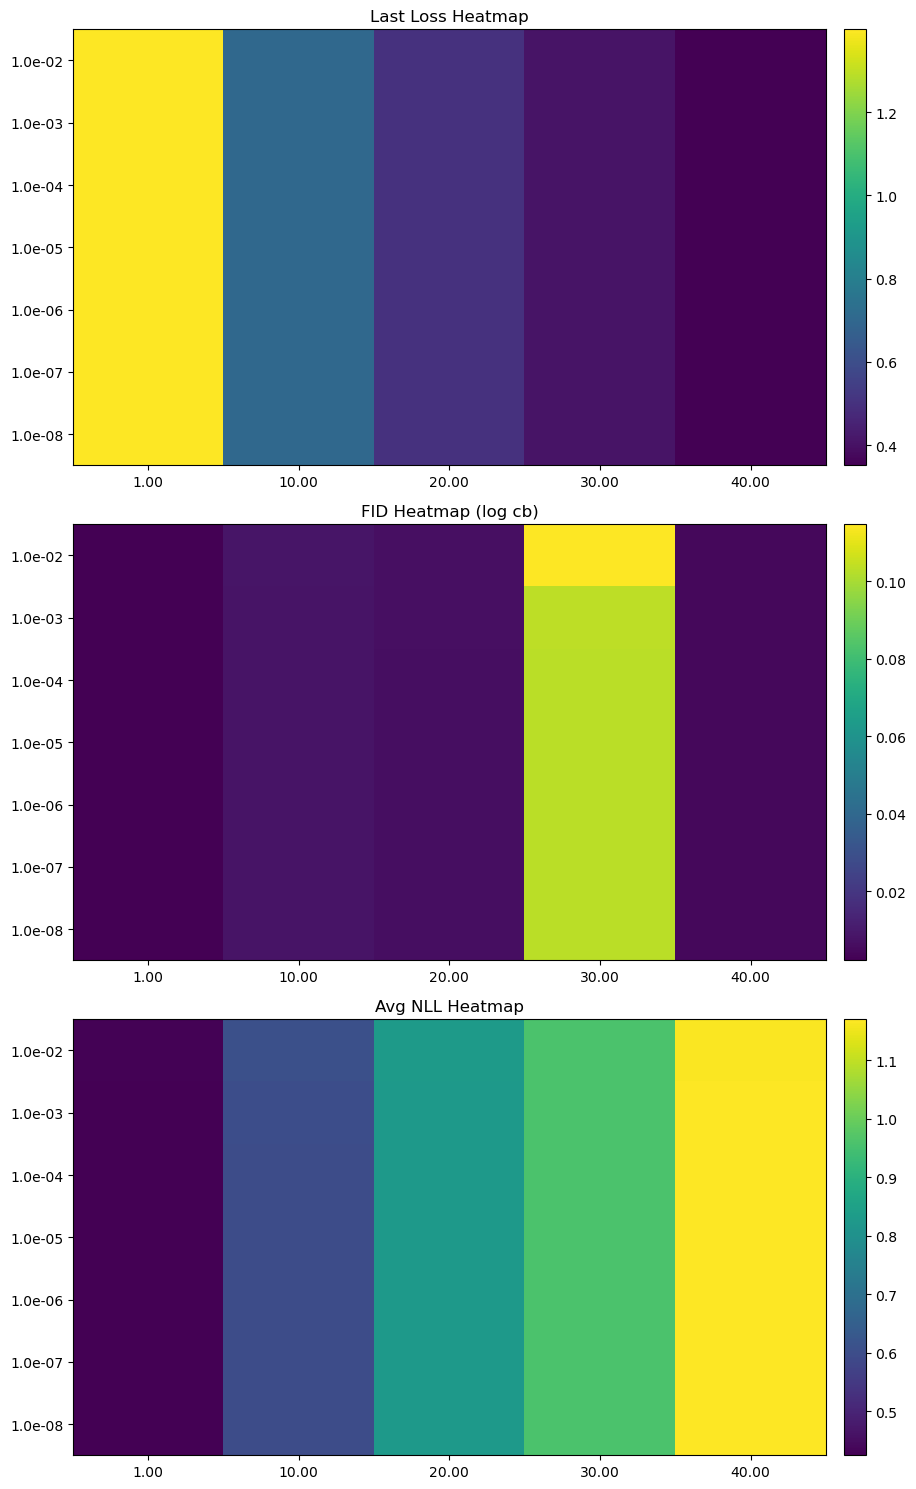

In [32]:
import matplotlib.pyplot as plt

# Dummy DataFrame for demonstration purposes
import numpy as np
import pandas as pd

# Reshape columns to matrix form for heatmap
last_loss_matrix = results_df.pivot(index='beta_min', columns='beta_max', values='last_loss').values
fid_matrix = results_df.pivot(index='beta_min', columns='beta_max', values='fid').values
avg_nll_matrix = results_df.pivot(index='beta_min', columns='beta_max', values='avg_nll').values
log_fid_matrix = np.log1p(fid_matrix)

# Plotting heatmaps
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# Last Loss heatmap
cax1 = ax[0].imshow(last_loss_matrix[:,:5], aspect='auto', origin='lower', cmap='viridis')
ax[0].set_title('Last Loss Heatmap')
ax[0].set_xticks(np.arange(len(beta_max_values)))
ax[0].set_yticks(np.arange(len(beta_min_values)))
ax[0].set_xticklabels([f"{val:.2f}" for val in beta_max_values])
ax[0].set_yticklabels([f"{val:.1e}" for val in beta_min_values])
fig.colorbar(cax1, ax=ax[0], orientation='vertical', pad=0.02)

# FID heatmap
cax2 = ax[1].imshow(log_fid_matrix[:,:5], aspect='auto', origin='lower', cmap='viridis')
ax[1].set_title('FID Heatmap (log cb)')
ax[1].set_xticks(np.arange(len(beta_max_values)))
ax[1].set_yticks(np.arange(len(beta_min_values)))
ax[1].set_xticklabels([f"{val:.2f}" for val in beta_max_values])
ax[1].set_yticklabels([f"{val:.1e}" for val in beta_min_values])
fig.colorbar(cax2, ax=ax[1], orientation='vertical', pad=0.02)

# Avg NLL heatmap
cax3 = ax[2].imshow(avg_nll_matrix[:,:5], aspect='auto', origin='lower', cmap='viridis')
ax[2].set_title('Avg NLL Heatmap')
ax[2].set_xticks(np.arange(len(beta_max_values)))
ax[2].set_yticks(np.arange(len(beta_min_values)))
ax[2].set_xticklabels([f"{val:.2f}" for val in beta_max_values])
ax[2].set_yticklabels([f"{val:.1e}" for val in beta_min_values])
fig.colorbar(cax3, ax=ax[2], orientation='vertical', pad=0.02)

plt.tight_layout()
plt.show()


In [10]:
last_loss_matrix

array([[0.9065555 , 0.77404733, 0.33314515, 0.08110139, 0.40724117,
        0.23223414, 0.13248763, 0.05342718, 0.72559436, 0.01142746],
       [0.77058075, 0.14694665, 0.07952208, 0.08960303, 0.67204781,
        0.24536721, 0.42053947, 0.55736879, 0.86055117, 0.72704426],
       [0.27032791, 0.1314828 , 0.05537432, 0.30159863, 0.26211815,
        0.45614057, 0.68328134, 0.69562545, 0.28351885, 0.37992696],
       [0.18115096, 0.78854551, 0.05684808, 0.69699724, 0.7786954 ,
        0.77740756, 0.25942256, 0.37381314, 0.58759964, 0.2728219 ],
       [0.3708528 , 0.19705428, 0.45985588, 0.0446123 , 0.79979588,
        0.07695645, 0.51883515, 0.3068101 , 0.57754295, 0.95943334],
       [0.64557024, 0.03536244, 0.43040244, 0.51001685, 0.53617749,
        0.68139251, 0.2775961 , 0.12886057, 0.39267568, 0.95640572],
       [0.18713089, 0.90398395, 0.54380595, 0.45691142, 0.88204141,
        0.45860396, 0.72416764, 0.39902532, 0.90404439, 0.69002502],
       [0.69962205, 0.3277204 , 0.7567786

In [9]:
np.hstack((np.array([1]),np.linspace(10, 100, num=10)))

array([  1.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.])

In [6]:
hidden_size = 128
hidden_layers = 6
embedding_size = 128
time_embedding = 'sinusoidal'
input_embedding = 'sinusoidal'
cond_embedding = 'sinusoidal'
device='cuda'
model = MLP_SS(
        hidden_size=hidden_size,
        hidden_layers=hidden_layers,
        emb_size=embedding_size,
        time_emb=time_embedding,
        input_emb=input_embedding).to(device)
model.load_state_dict(torch.load('mdl_weights/0.0001_0.5.pth'))

beta_min = 1e-4
beta_max = 0.5
vp = uncon_VP_1D(beta_min, beta_max)

In [12]:
latent = torch.randn(train_data_length, 2, device=device)
samples = edm_sampler(model, latent, None, 100, pfgmpp=True)
#samples, _ = vp_ode_sampler(model, vp, train_data.shape, device)
samples = samples.detach().cpu().numpy()

In [10]:
vp = uncon_VP_1D(beta_min, beta_max)
vp_sampler = uncon_EulerMaruyama(1000, 1e-5, train_data_length)
vp_ode_sampler = ODE_uncon_EulerMaruyama(1000, 1e-5, 10000, 1e-5, 1e-5)
samples, _ = vp_sampler(model, vp, train_data.shape, device)
#samples, _ = vp_ode_sampler(model, vp, train_data.shape, device)
samples = samples.detach().cpu().numpy()

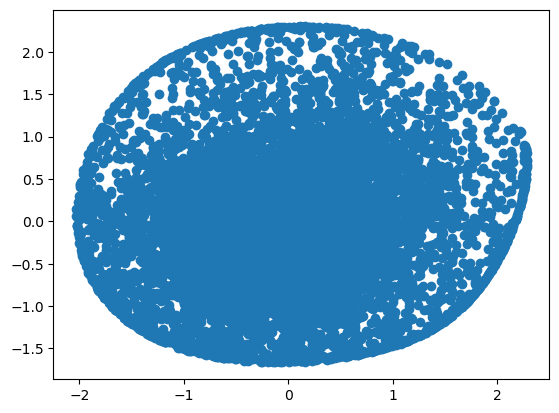

In [13]:
plt.scatter(samples[:,0], samples[:,1])
#plt.xlim((-5,5))
#plt.ylim((-5,5))

In [17]:
fid_metric(samples, train_data.detach().cpu().numpy())

1.557473002914324e+17

In [8]:
inverse_scaler = 1 # dummy param
likelihood_fn = get_likelihood_fn(vp, inverse_scaler)
bpd = likelihood_fn(model, train_data.to(device))[0]

tensor([ 1.3225, -0.6731,  1.8295,  ...,  1.5394,  2.7051,  1.6966],
       device='cuda:0')


In [13]:
np.mean(bpd.detach().cpu().numpy())

1.6767131